In [262]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD, NMF
from nltk.corpus import stopwords
from string import punctuation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import Lasso

%matplotlib inline

In [126]:
train = pd.read_csv('data/train_sample.tsv', delimiter = '\t')
# train = pd.read_csv('data/train.tsv', delimiter = '\t')

In [127]:
train.head()
# NOTE: category_name --> string, hierarchical (L->R)
# NOTE: brand_name --> string, can this be boolean?
# NOTE: item_description --> string, needs nlp

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [128]:
train.columns

Index([u'train_id', u'name', u'item_condition_id', u'category_name',
       u'brand_name', u'price', u'shipping', u'item_description'],
      dtype='object')

In [129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 8 columns):
train_id             998 non-null int64
name                 998 non-null object
item_condition_id    998 non-null int64
category_name        994 non-null object
brand_name           581 non-null object
price                998 non-null float64
shipping             998 non-null int64
item_description     998 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 62.4+ KB


In [130]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
train_id,998.0,498.500000,288.242086,0.0,249.25,498.5,747.75,997.0
item_condition_id,998.0,1.888778,0.916063,1.0,1.00,2.0,3.00,5.0
price,998.0,27.924850,45.903319,3.0,10.00,16.0,29.00,650.0
shipping,998.0,0.449900,0.497733,0.0,0.00,0.0,1.00,1.0


In [131]:
five_condition = train[train['item_condition_id'] == 5]
five_condition.head()
# NOTE: item condition is 1-5 scale where 1 is the best and 5 is the worst

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
653,653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet


In [132]:
max_price = np.max(train['price'])
most_expensive = train[train['price'] == max_price]
most_expensive
min_price = np.min(train['price'])
least_expensive = train[train['price'] == min_price]
least_expensive.head()
# NOTE: There are a lot of items with no cost (874)
# even though they have good condition and require shipping

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
88,88,Misty tentacruel foil pokemon card,3,Vintage & Collectibles/Trading Cards/Animation,Pokemon,3.0,1,I have 2 available
203,203,Racerback tank top,3,"Women/Tops & Blouses/Tank, Cami",NaN,3.0,1,Tiny hole at the back barely noticeable
240,240,1998 SP Authentic Derek Jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,1998 SP Authentic Derek Jeter #145
390,390,nails and nail polish set,1,Beauty/Makeup/Nails,NaN,3.0,1,Comes with both.
444,444,35 thank you stickers free shipping,1,Other/Office supplies/Shipping Supplies,NaN,3.0,1,Free shipping You'll receive 7 strips of 5 sti...


In [133]:
len(train['brand_name'].value_counts())

229

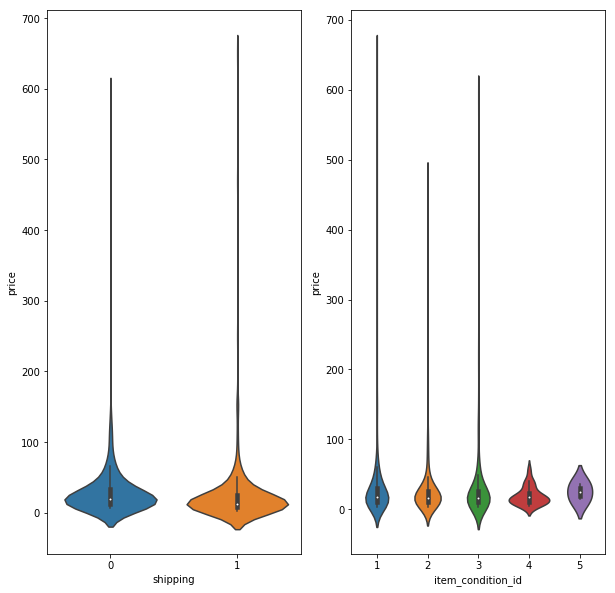

In [134]:
fig, ax_arr = plt.subplots(1,2, figsize=(10,10))
print (ax_arr)
sns.violinplot(train['shipping'], train['price'], ax=ax_arr[0])
sns.violinplot(train['item_condition_id'], train['price'], ax=ax_arr[1])


In [135]:
no_shipping = np.mean(train[train['shipping'] == 0]['price'])
shipping = np.mean(train[train['shipping'] == 1]['price'])
print ('AVG NO SHIPPING: {}'.format((no_shipping)))
print ('AVG WITH SHIPPING: {}'.format((shipping)))

AVG NO SHIPPING: 31.4881602914
AVG WITH SHIPPING: 23.5679287305


In [136]:
train['category_name'] = train['category_name'].fillna('None/None/None')
mask = train['category_name'] == 'None/None/None'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,None/None/None,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,None/None/None,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,None/None/None,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,None/None/None,Michael Kors,18.0,0,No description yet


In [137]:
train['brand_name'] = train['brand_name'].fillna('no_label')
mask = train['brand_name'] == 'no_label'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,no_label,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,no_label,8.0,0,I realized his pants are on backwards after th...
17,17,New: Baby K'tan active baby carrier,1,Kids/Gear/Backpacks & Carriers,no_label,29.0,1,Brand new in box Size: Medium Color: Coral Ret...
23,23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,no_label,8.0,1,Brand new never used All colors are available ...
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
34,34,Four puppy dog stuffed animal ty,3,Kids/Toys/Stuffed Animals & Plush,no_label,5.0,1,2 beanie babies pugsley wrinkles Puppy with pu...
35,35,Black Capri Leggings w/ Flowers One size,1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,13.0,1,One size fits sizes 2-12 92% polyester 8% span...


In [138]:
train['item_description'] = train['item_description'].fillna('No description yet')
mask = train['item_description'] == 'No description yet'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,no_label,5.0,1,No description yet
129,129,Primitive pillow,2,Home/Home Décor/Home Décor Accents,no_label,9.0,0,No description yet
172,172,Toddler Nike tennis shoes,3,Kids/Boys 0-24 Mos/Shoes,Nike,10.0,0,No description yet
195,195,Black Toms,4,Women/Shoes/Loafers & Slip-Ons,no_label,8.0,1,No description yet
214,214,XXS lularoe Carly,1,Women/Dresses/Asymmetrical Hem,no_label,55.0,1,No description yet
218,218,Scentsy testers (36),3,Home/Home Décor/Home Fragrance,Scentsy,21.0,1,No description yet


In [139]:
top, middle, bottom = [], [], []
for i, row in train.iterrows():
    hierarchy_string = row['category_name']
#     print (hierarchy_string)
    hierarchy_list = hierarchy_string.split('/')
#     print ('1: {}, 2: {}, 3: {}'.format(hierarchy_list[0], hierarchy_list[1], hierarchy_list[2]))
    top.append(hierarchy_list[0])
    middle.append(hierarchy_list[1])
    bottom.append(hierarchy_list[2])
train['category_top'] = top
train['category_middle'] = middle
train['category_bottom'] = bottom

there are 11 top, 77 middle, and 215 bottom categories


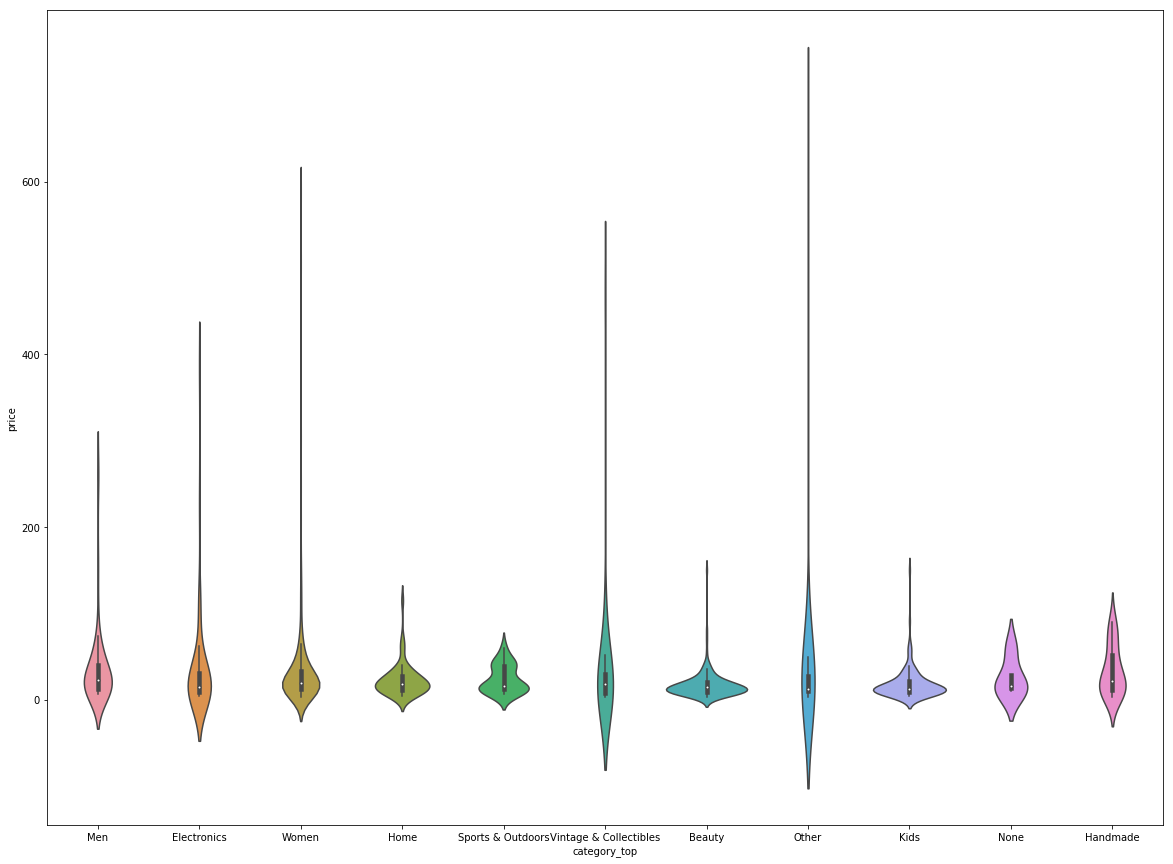

In [140]:
top_count = len(set(top))
middle_count = len(set(middle))
bottom_count = len(set(bottom))
print ('there are {} top, {} middle, and {} bottom categories'.format(top_count, middle_count, bottom_count))

fig, ax_arr = plt.subplots(1,1, figsize=(20,15))
sns.violinplot(train['category_top'], train['price'], ax=ax_arr)

In [141]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_top,category_middle,category_bottom
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [142]:
train['category_middle'].value_counts()

Makeup                       98
Athletic Apparel             83
Shoes                        77
Tops & Blouses               67
Jewelry                      39
Toys                         37
Women's Handbags             32
Cell Phones & Accessories    31
Sweaters                     31
Dresses                      31
Fragrance                    21
Women's Accessories          21
Jeans                        20
Underwear                    20
Kitchen & Dining             18
Boys 0-24 Mos                18
Home Décor                   18
Skin Care                    16
Girls 0-24 Mos               16
Swimwear                     16
Other                        16
Coats & Jackets              15
Girls 2T-5T                  15
Tops                         14
Video Games & Consoles       14
Boys 2T-5T                   12
Daily & Travel items         12
Men's Accessories            11
Tools & Accessories          10
Girls (4+)                    9
                             ..
None    

In [143]:
stop_words = set(stopwords.words('english'))
    
def tokenize(string):
    clean_list = []
    description = string.lower()
    desc_list = description.split()
    for word in desc_list:
        word = word.strip(punctuation)
        if len(word) > 0:
            clean_list.append(word)
    return clean_list

def remove_stopwords(token_list):
    no_stop_words = [word for word in token_list if word not in stop_words]
    return no_stop_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(token_list):
    alphabet = set(['a','b','c','d','e','f','g','h','i','j','k','l','m'
                    'n','o','p','q','r','s','t','u','v','w','x','y','z'])
    lemmatizer = wnl()
    lemmed_tokens = []
    tagged = nltk.pos_tag(token_list)
    for word, pos_tag in tagged:
        word = ''.join([letter for letter in word if letter in alphabet])
        lemmed_word = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos_tag))
        lemmed_tokens.append(lemmed_word)
    return lemmed_tokens

In [144]:
train['description_tokens'] = train['item_description'].apply(lambda x: tokenize(x))

In [145]:
train['description_tokens'] = train['description_tokens'].apply(lambda x: remove_stopwords(x))

In [146]:
train['lemmed_tokens'] = train['description_tokens'].apply(lambda x: lemmatize(x))

In [147]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
vectorizer.fit(train['lemmed_tokens'])
desc_vect = vectorizer.transform(train['lemmed_tokens'])

In [148]:
no_lem_vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
no_lem_vectorizer.fit(train['description_tokens'])
no_lem_vect = no_lem_vectorizer.transform(train['description_tokens'])

In [149]:
no_lem_trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
no_lem_trunc_svd.fit(no_lem_vect)
reduced_no_lem_vect = no_lem_trunc_svd.transform(no_lem_vect)

In [150]:
trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
trunc_svd.fit(desc_vect)
reduced_vect = trunc_svd.transform(desc_vect)

In [151]:
len(no_lem_vectorizer.vocabulary_)

4718

In [152]:
len(vectorizer.vocabulary_)

3836

In [153]:
sum(trunc_svd.explained_variance_ratio_)

0.50860093330945921

In [154]:
lem_train, lem_test, y_lem_train, y_lem_test = train_test_split(reduced_vect,
                                                                train['price'], test_size=0.2)
no_lem_train, no_lem_test, y_no_lem_train, y_no_lem_test = train_test_split(reduced_no_lem_vect, 
                                                                            train['price'], test_size=0.2)

In [155]:
rf_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_lem = GradientBoostingRegressor(verbose=3)
rf_no_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_no_lem = GradientBoostingRegressor(verbose=3)
gb_lem.fit(lem_train, y_lem_train)
rf_lem.fit(lem_train, y_lem_train)
gb_no_lem.fit(no_lem_train, y_no_lem_train)
rf_no_lem.fit(no_lem_train, y_no_lem_train)

      Iter       Train Loss   Remaining Time 
         1        2011.4690            3.26s
         2        1887.4527            2.21s
         3        1786.8345            1.92s
         4        1716.6635            1.79s
         5        1659.6845            1.62s
         6        1595.1714            1.52s
         7        1537.7735            1.47s
         8        1498.1019            1.41s
         9        1454.9348            1.37s
        10        1425.9532            1.36s
        11        1404.8176            1.34s
        12        1373.8314            1.31s
        13        1351.0900            1.27s
        14        1330.7153            1.23s
        15        1297.2096            1.21s
        16        1283.8343            1.19s
        17        1250.2832            1.18s
        18        1230.0952            1.18s
        19        1194.6421            1.17s
        20        1171.7644            1.17s
        21        1145.7292            1.16s
        2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.7s finished


      Iter       Train Loss   Remaining Time 
         1        2303.4680            1.54s
         2        2203.8704            1.38s
         3        2121.6842            1.26s
         4        2053.1136            1.19s
         5        1958.2417            1.15s
         6        1909.2120            1.17s
         7        1869.4694            1.12s
         8        1805.5007            1.10s
         9        1727.1593            1.08s
        10        1701.7432            1.05s
        11        1637.5348            1.03s
        12        1585.2395            1.01s
        13        1507.4951            0.99s
        14        1445.4655            0.99s
        15        1407.1197            1.00s
        16        1372.0440            0.99s
        17        1337.3609            1.00s
        18        1289.5103            1.03s
        19        1264.6313            1.04s
        20        1231.7431            1.03s
        21        1198.5030            1.01s
        2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=3, warm_start=False)

In [156]:
print 'Gradient Boosted lemmatized R**2 score: {}'.format(gb_lem.score(lem_train, y_lem_train))
print 'Random Forest lemmatized R**2 score: {}'.format(rf_lem.score(lem_train, y_lem_train))
print 'Gradient Boosted non-lemmatized R**2 score: {}'.format(gb_no_lem.score(no_lem_train, y_no_lem_train))
print 'Random Forest non-lemmatized R**2 score: {}'.format(rf_no_lem.score(no_lem_train, y_no_lem_train))

Gradient Boosted lemmatized R**2 score: 0.683104413918
Random Forest lemmatized R**2 score: 0.626639668984
Gradient Boosted non-lemmatized R**2 score: 0.725295372594
Random Forest non-lemmatized R**2 score: 0.671082482329


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [157]:
train[train['price'] > 400].sort_values('price', ascending=False)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_top,category_middle,category_bottom,description_tokens,lemmed_tokens
264,264,Ricky Garner,1,Other/Other/Other,no_label,650.0,1,No description yet,Other,Other,Other,"[description, yet]","[descriptio, yet]"
877,877,Christian louboutin Tudor bal 100,3,Women/Shoes/Pumps,Christian Louboutin,589.0,0,"It's in great condition used, shoes have some ...",Women,Shoes,Pumps,"[it's, great, condition, used, shoes, marks, h...","[its, great, coditio, use, shoe, ark, hard, te..."
543,543,Burberry Small Canterbury Horseshoe Tote,1,Women/Women's Handbags/Totes & Shoppers,Burberry,506.0,0,"RETAILS: [rm],250.00 Just the right size to ta...",Women,Women's Handbags,Totes & Shoppers,"[retails, rm],250.00, right, size, take, work,...","[retail, r, right, size, take, work, weeked, c..."
216,216,YSL OTL BDJ Chevrette 2A Clutch NEW,2,Vintage & Collectibles/Bags and Purses/Clutch,YSL Yves Saint Laurent,470.0,1,Price firm. All offers will be declined. Origi...,Vintage & Collectibles,Bags and Purses,Clutch,"[price, firm, offers, declined, original, pric...","[price, fir, offer, declied, origial, price, r..."


In [231]:
nmf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(2, 3))
no_lem_vectorized = nmf_vectorizer.fit_transform(train['item_description'])

no_lem_nmf_descriptions = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(no_lem_vectorized)
no_lem_nmf_topics = no_lem_nmf_descriptions.transform(no_lem_vectorized)

In [232]:
nmf_fit = nmf_vectorizer.fit(train['item_description'])
non_lem_words = nmf_fit.get_feature_names()

In [237]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [238]:
print_top_words(no_lem_nmf_descriptions, non_lem_words, 15)

Topic #0:
brand new, brand new box, new box, brand new tags, new tags, new tag, brand new tag, brand new sealed, size women, new sealed, brand new opened, new opened, brand new worn, price firm, brand new size
Topic #1:
great condition, ship day, times great condition, bundle rm, hardly used, times great, condition comes, worn great condition, worn great, worn times, size 12, great condition size, boots great, zipper closure, blue black
Topic #2:
super cute, new tags, size women, cute shirt, ready used, brand new tags, xl fits, christmas gift, shown photo, small wallet, fits like, zip button, price firm order, barely noticeable, great christmas
Topic #3:
free shipping, new free, new free shipping, size fits, fast shipping, fast free, fast free shipping, shipped envelope, brandy melville, like new free, nave shirts, nave shirts carter, like new, new fast, new fast free
Topic #4:
size medium, tshirt size, like new size, size medium worn, medium worn, new size, medium great, flower design

In [241]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, ngram_range=(2, 3))
vectorizer.fit(train['lemmed_tokens'])
lem_vectorized = vectorizer.transform(train['lemmed_tokens'])

lem_nmf_descriptions = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(lem_vectorized)
lem_nmf_topics = lem_nmf_descriptions.transform(lem_vectorized)

In [242]:
nmf_fit = vectorizer.fit(train['lemmed_tokens'])
lem_words = nmf_fit.get_feature_names()
print_top_words(lem_nmf_descriptions, lem_words, 15)

Topic #0:
descriptio yet, zoo caera perfect, ew  authetic, evet ever use, evets christopher, evets christopher robi, eviroet aura, eviroet aura ifused, eviroetal ood, eviroetal ood swig, evolutio woa, evolutio woa color, ew , ew  flavor, everythig happy
Topic #1:
brad ew, brad ew tag, brad ew ever, ew tag, brad ew box, tag whiteburgudy, ew tag whiteburgudy, ever opeed, ew ever opeed, brad ew seal, ew adorable, ew  authetic, ew authetic absolutely, eviroet aura ifused, ew authetic
Topic #2:
size , wor size, wor size , ever wor size,  woe, size  woe, size  wor,  wor, ew size , woe size , woe size, size  ew, size  , evets christopher, evet ever use
Topic #3:
ever use, ew ever use, ew ever, brad ew ever, ever use color, use color, color chihuahua, use color chihuahua, ew ever wor, ew ever opeed, brad ew, ever opeed, use color available, color available r, color available
Topic #4:
ever wor, ew ever wor, ever wor size, wor size, wor size , ew ever, wt ever wor, wt ever, ever wor flaw, wor f

In [259]:
X_train_hash, X_test_hash, y_train_hash, y_test_hash = train_test_split(train['brand_name'],
                                                                train['price'], test_size=0.2)

In [260]:
h = FeatureHasher(n_features=100,input_type="string")
X_train_hash = h.transform(X_train_hash.values)
X_test_hash = h.transform(X_test_hash.values)
l.fit(X_train_hash, y_lem_train)
y_pred = l.predict_proba(X_test_hash)
print(log_loss(y_test, y_pred))
r.fit(X_train_hash, y_lem_train)
y_pred = r.predict_proba(X_test_hash)
print(log_loss(y_lem_test, y_pred))

NameError: name 'l' is not defined